In [1]:
import geopandas as gpd
import networkx as nx
import geopy
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.approximation as nx_app
import math

%matplotlib inline
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings(action = "ignore")

# Hamilton Cycles

A hamilton cycle is a cycle in a graph passing through all the vertices once.

https://www.yumpu.com/en/document/read/6389855/chapter-10-the-traveling-salesman-problem

There are (n-1)! unique cycles possible in a hamilton cycle if we consider A-B-C-D-A and its opposite A-D-C-B-A as separate cycles. Or else, there are (n-1)!/2 cycles possible in a graph.

https://math.stackexchange.com/questions/249817/how-many-hamiltonian-cycles-are-there-in-a-complete-graph-k-n-n-geq-3-why

## Sample cities: Berlin, Dusseldorf, Hamburg and Munich

In [2]:
from itertools import permutations

cities = ["Berlin","Dusseldorf","Hamburg","Munich","Berlin"]
start, *rest, end = cities

#start and end are both Berlin.
#We need to get permutation of rest of the cities considering all of them
#3P3 = 3!/0! = 6 = (4-1)!
paths = [(start, *path, end) for path in permutations(rest,len(rest))]
paths

[('Berlin', 'Dusseldorf', 'Hamburg', 'Munich', 'Berlin'),
 ('Berlin', 'Dusseldorf', 'Munich', 'Hamburg', 'Berlin'),
 ('Berlin', 'Hamburg', 'Dusseldorf', 'Munich', 'Berlin'),
 ('Berlin', 'Hamburg', 'Munich', 'Dusseldorf', 'Berlin'),
 ('Berlin', 'Munich', 'Dusseldorf', 'Hamburg', 'Berlin'),
 ('Berlin', 'Munich', 'Hamburg', 'Dusseldorf', 'Berlin')]

A "prefix tree" represents the prefix structure of the strings. Each node represents the empty prefix with children for the single letter prefixes which in turn have children for each double letter prefix starting with the single letter corresponding to the parent node, and so on.

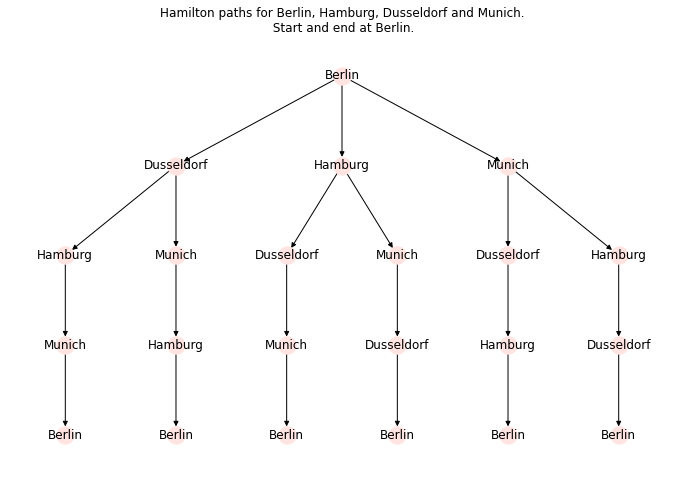

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

cities = ["Berlin","Dusseldorf","Hamburg","Munich","Berlin"]

def make_tsp_tree(cities):
    """
    Create all Hamilton paths from start to end city from a list of cities.
    Creates a directed prefix tree from a list of the created paths. 
    Remove the root node and nil node.
    """
    start, *rest, end = cities
    paths = [(start, *path, end) for path in permutations(rest)]
    
    #Creates a directed prefix from a list of paths
    G = nx.prefix_tree(paths)
    
    #remove synthetic root node (None) and nil node (NIL)
    G.remove_nodes_from([0, -1])
    
    return G

#Get graph object with all Hamilton paths
G = make_tsp_tree(cities)

#Create node positions for G using Graphviz.
#Available layouts: https://graphviz.org/docs/layouts/
#dot gives hierarchical or layered drawings of directed graphs
#possible layouts: dot, neato, twopi, circo, fdp, osage, patchwork, sfdp
positions = nx.nx_agraph.graphviz_layout(G, "dot")

plt.figure(figsize = (12,8))

#Draw networkx Graph object with labels off
nx.draw_networkx(G,
                 pos = positions,
                 node_color = "mistyrose",
                 with_labels= False)

#Draw NetworkX Graph object with defined labels for each node
nx.draw_networkx_labels(G,
                        pos = positions,
                        labels = dict(G.nodes(data = "source")))

plt.title("Hamilton paths for Berlin, Hamburg, Dusseldorf and Munich.\n Start and end at Berlin.")
plt.axis("off")

#plt.savefig("all possible paths.jpeg",
#           dpi = 300)
plt.show()

# Geocoding

In [4]:
def get_coordinates(place):
    place_details = geolocator.geocode(place)
    
    coordinates = (place_details[1][0], place_details[1][1])
    
    #latitude, longitude
    return coordinates[1], coordinates[0]

<AxesSubplot:>

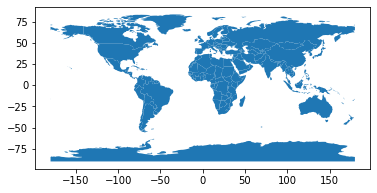

In [5]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.plot()

<AxesSubplot:>

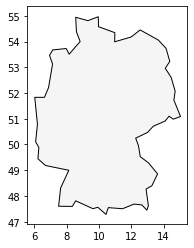

In [6]:
germany = world[world.name == "Germany"]
germany.plot(color = "whitesmoke", edgecolor = "black")

In [7]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "app")

capitals = ['Berlin', 'Bremen', 'Dresden', 'Dusseldorf', 'Erfurt', 'Hamburg', 'Hannover', 'Kiel',
            'Magdeburg', 'Mainz', 'Munich', 'Potsdam', 'Saarbrucken', 'Schwerin', 'Stuttgart', 'Wiesbaden']

#Initialise empty list to get coordinates of each city
coordinates = []

for capital in capitals:
    globals()["%s_coordinate"%capital] = get_coordinates(capital)
    coordinates.append(globals()["%s_coordinate"%capital])
    
coordinates

[(13.3888599, 52.5170365),
 (8.8071646, 53.0758196),
 (13.7381437, 51.0493286),
 (6.7763137, 51.2254018),
 (11.0287364, 50.9777974),
 (10.000654, 53.550341),
 (9.7385532, 52.3744779),
 (10.135555, 54.3227085),
 (11.6399609, 52.1315889),
 (8.2762513, 50.0012314),
 (11.5753822, 48.1371079),
 (13.0591397, 52.4009309),
 (6.997495426501035, 49.247108100000005),
 (11.4148038, 53.6288297),
 (9.1800132, 48.7784485),
 (8.2416556, 50.0820384)]

In [8]:
i = 1
for x, y in coordinates:
    print (i, y*1000, x*1000)
    i+=1

1 52517.0365 13388.8599
2 53075.8196 8807.1646
3 51049.3286 13738.1437
4 51225.4018 6776.313700000001
5 50977.7974 11028.7364
6 53550.341 10000.654
7 52374.477900000005 9738.5532
8 54322.7085 10135.555
9 52131.588899999995 11639.9609
10 50001.231400000004 8276.2513
11 48137.107899999995 11575.3822
12 52400.9309 13059.1397
13 49247.108100000005 6997.495426501036
14 53628.829699999995 11414.8038
15 48778.448500000006 9180.0132
16 50082.038400000005 8241.6556


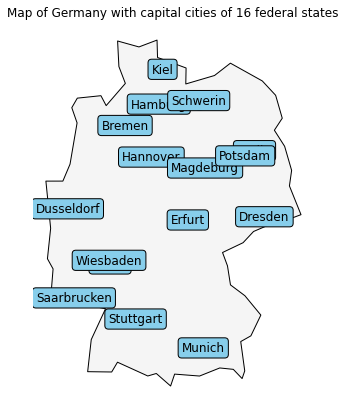

In [9]:
G = nx.Graph()
#Create a graph object with number of nodes same as number of cities
nodes = np.arange(0, len(capitals))
G.add_nodes_from(nodes)

#Create a dictionary of node and coordinate of each state for positions
positions = {node:coordinate for node, coordinate in zip(nodes, coordinates)}

#Create a dictionary of node and capital for labels
labels = {node:capital for node, capital in zip(nodes, capitals)}

fig, ax = plt.subplots(figsize = (10, 7))
germany.plot(color = "whitesmoke", edgecolor = "black", ax = ax)
nx.draw_networkx(G, pos = positions,
                 labels = labels, ax = ax,
                 bbox = dict(facecolor = "skyblue", boxstyle = "round",
                             ec = "black", pad = 0.3),)

plt.title("Map of Germany with capital cities of 16 federal states")
plt.axis("off")
plt.show()

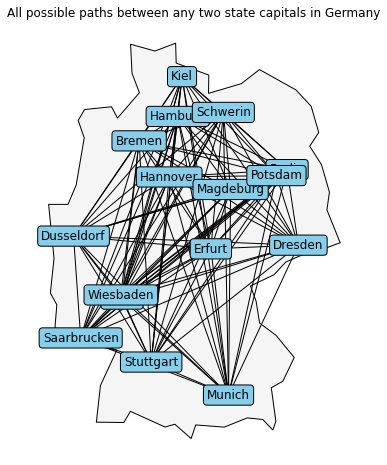

In [10]:
for i in nodes:
    for j in nodes:
        if i!=j:
            G.add_edge(i, j)

fig, ax = plt.subplots(figsize = (12, 8))

germany.plot(color = "whitesmoke", edgecolor = "black", ax = ax)

nx.draw_networkx(G, pos = positions, labels = labels,
                 bbox = dict(facecolor = "skyblue", boxstyle = "round",
                             ec = "black", pad = 0.3),
                 ax = ax)

plt.title("All possible paths between any two state capitals in Germany")

plt.axis("off")
plt.savefig("all possible paths.jpeg",
           dpi = 300)
plt.show()

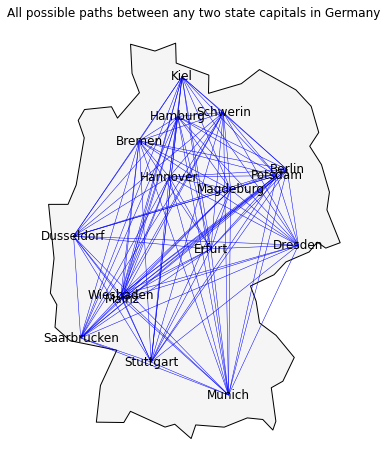

In [11]:
for i in nodes:
    for j in nodes:
        if i!=j:
            G.add_edge(i, j)

fig, ax = plt.subplots(figsize = (12, 8))

germany.plot(color = "whitesmoke", edgecolor = "black", ax = ax)

nx.draw_networkx(G, pos = positions,
                 labels = labels,
                 edge_color = "blue",
                 node_size = 0,
                 width = 0.5,
                 ax = ax)

plt.title("All possible paths between any two state capitals in Germany")

plt.axis("off")
plt.savefig("../output/all possible paths.jpeg",
           dpi = 300)
plt.show()

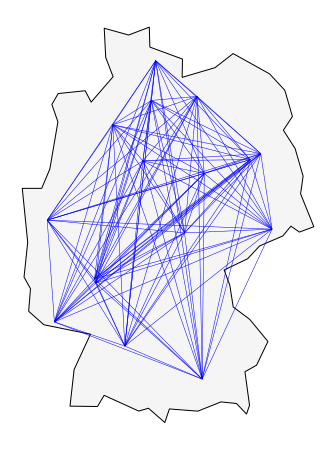

In [12]:
fig, ax = plt.subplots(figsize = (12, 8))

germany.plot(color = "whitesmoke", edgecolor = "black", ax = ax)

#Create a dictionary of node and capital for labels
labels = {node:capital for node, capital in zip(nodes, capitals)}

# Draw closest edges on each node only
nx.draw_networkx_edges(G, 
                       pos = positions,
                       edge_color="blue", width=0.5, ax = ax)

plt.axis("off")

plt.show()


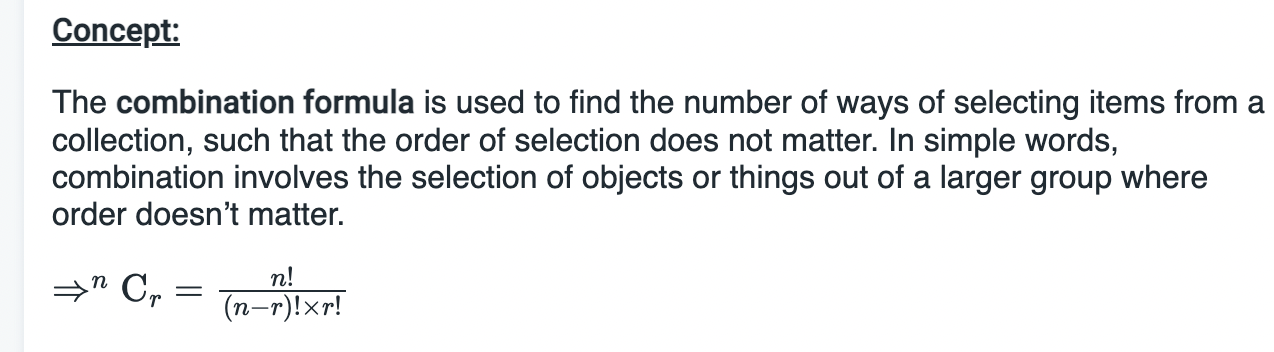

Total number of possible paths = n(n-1)/2 = 16*15/2 

In [13]:
len(G.edges)

120

In [14]:
pos = {node:list(coordinate) for node, coordinate in zip(nodes, coordinates)}
pos

{0: [13.3888599, 52.5170365],
 1: [8.8071646, 53.0758196],
 2: [13.7381437, 51.0493286],
 3: [6.7763137, 51.2254018],
 4: [11.0287364, 50.9777974],
 5: [10.000654, 53.550341],
 6: [9.7385532, 52.3744779],
 7: [10.135555, 54.3227085],
 8: [11.6399609, 52.1315889],
 9: [8.2762513, 50.0012314],
 10: [11.5753822, 48.1371079],
 11: [13.0591397, 52.4009309],
 12: [6.997495426501035, 49.247108100000005],
 13: [11.4148038, 53.6288297],
 14: [9.1800132, 48.7784485],
 15: [8.2416556, 50.0820384]}

https://networkx.org/documentation/stable/auto_examples/drawing/plot_tsp.html#sphx-glr-auto-examples-drawing-plot-tsp-py

In [15]:
H = G.copy()

# Calculating the distances between the nodes as edge's weight.
for i in range(len(pos)):
    for j in range(i + 1, len(pos)):
        
        #Multidimensional Euclidean distance from the origin to a point.
        #euclidean distance between (x1, y1) and (x2, y2) is ((x2-x1)**2 + (y2-y1)**2)**0.5
        dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
        dist = dist
        G.add_edge(i, j, weight=dist)
        


cycle = nx_app.christofides(G, weight="weight")

edge_list = list(nx.utils.pairwise(cycle))

# Christofides algorithm explained step by step

In [16]:
#Remove selfloops if necessary
loop_nodes = nx.nodes_with_selfloops(G)

try:
    node = next(loop_nodes)
except StopIteration:
    pass
else:
    G = G.copy()
    G.remove_edge(node, node)
    G.remove_edges_from((n, n) for n in loop_nodes)

In [17]:
# Check that G is a complete graph
N = len(G) - 1

# This check ignores selfloops which is what we want here.
if any(len(nbrdict) != N for n, nbrdict in G.adj.items()):
    raise nx.NetworkXError("G must be a complete graph.")

### 1. Create a minimum spanning tree <i>T</i> of <i>G</i>

In [18]:
tree = nx.minimum_spanning_tree(G, weight="weight")
    
tree

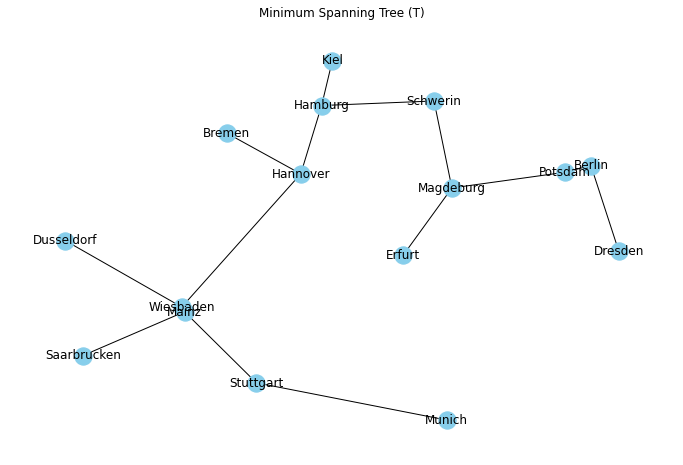

In [19]:
plt.figure(figsize = (12, 8))
nx.draw_networkx(tree, labels = labels, pos = positions,
                #node_size = 100,
                node_color = "skyblue")

plt.title("Minimum Spanning Tree (T)")

plt.axis("off")

plt.savefig("../output/minimum spanning tree.jpeg",
           dpi = 300)

### 2. Make a set of nodes in <i>T</i> with odd degree <i>O</i>

In [20]:
L = tree.copy()
L.remove_nodes_from([v for v, degree in tree.degree if not (degree % 2)])
L

In [21]:
L.nodes

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15))

In [22]:
labels

{0: 'Berlin',
 1: 'Bremen',
 2: 'Dresden',
 3: 'Dusseldorf',
 4: 'Erfurt',
 5: 'Hamburg',
 6: 'Hannover',
 7: 'Kiel',
 8: 'Magdeburg',
 9: 'Mainz',
 10: 'Munich',
 11: 'Potsdam',
 12: 'Saarbrucken',
 13: 'Schwerin',
 14: 'Stuttgart',
 15: 'Wiesbaden'}

Berlin, Potsdam, Schwerin and Stuttgart have even degree (2). So they are removed.

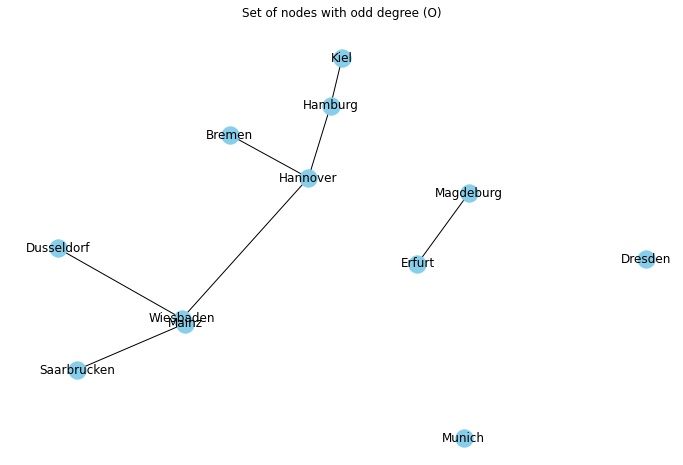

In [23]:
plt.figure(figsize = (12, 8))
nx.draw_networkx(L, pos = positions,
                labels = {node:labels[node] for node in L.nodes},
                node_color = "skyblue")

plt.title("Set of nodes with odd degree (O)")

plt.axis("off")

plt.savefig("../output/set of nodes with odd degree.jpeg",
           dpi = 300)

### 3. Find a minimum-weight perfect matching M in the induced subgraph given by the vertices from O.

In [24]:
def perfect_matching(G, weight = "weight", tree = None):
    loop_nodes = nx.nodes_with_selfloops(G)
    try:
        node = next(loop_nodes)
    except StopIteration:
        pass
    else:
        G = G.copy()
        G.remove_edge(node, node)
        G.remove_edges_from((n, n) for n in loop_nodes)
    # Check that G is a complete graph
    N = len(G) - 1
    # This check ignores selfloops which is what we want here.
    if any(len(nbrdict) != N for n, nbrdict in G.adj.items()):
        raise nx.NetworkXError("G must be a complete graph.")

    if tree is None:
        tree = nx.minimum_spanning_tree(G, weight=weight)
    L = G.copy()
    L.remove_nodes_from([v for v, degree in tree.degree if not (degree % 2)])
    MG = nx.MultiGraph()
    #MG.add_edges_from(tree.edges)
    edges = nx.min_weight_matching(L, maxcardinality=True, weight=weight)
    MG.add_edges_from(edges)
    return MG

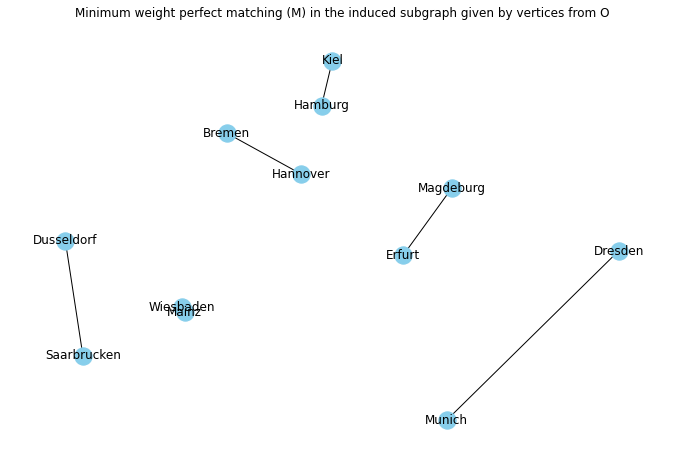

In [25]:
MG = perfect_matching(G)

plt.figure(figsize = (12, 8))

nx.draw_networkx(MG, labels = {node:labels[node] for node in MG.nodes},
                 pos = positions,
                node_color = "skyblue")

plt.title("Minimum weight perfect matching (M) in the induced subgraph given by vertices from O")

plt.axis("off")

plt.savefig("../output/Minimum weight perfect matching in M in the induced subgraph given by vertices from O.jpeg",
           dpi = 300)

### 4. Combine the edges of M and T to form a connected multigraph H in which each vertex has even degree.



In [26]:
def multigraph(G, weight = "weight", tree = None):
    loop_nodes = nx.nodes_with_selfloops(G)
    try:
        node = next(loop_nodes)
    except StopIteration:
        pass
    else:
        G = G.copy()
        G.remove_edge(node, node)
        G.remove_edges_from((n, n) for n in loop_nodes)
    # Check that G is a complete graph
    N = len(G) - 1
    # This check ignores selfloops which is what we want here.
    if any(len(nbrdict) != N for n, nbrdict in G.adj.items()):
        raise nx.NetworkXError("G must be a complete graph.")

    if tree is None:
        tree = nx.minimum_spanning_tree(G, weight=weight)
    L = G.copy()
    L.remove_nodes_from([v for v, degree in tree.degree if not (degree % 2)])
    MG = nx.MultiGraph()
    MG.add_edges_from(tree.edges)
    
    edges = nx.min_weight_matching(L, maxcardinality=True, weight=weight)
    MG.add_edges_from(edges)
    return MG

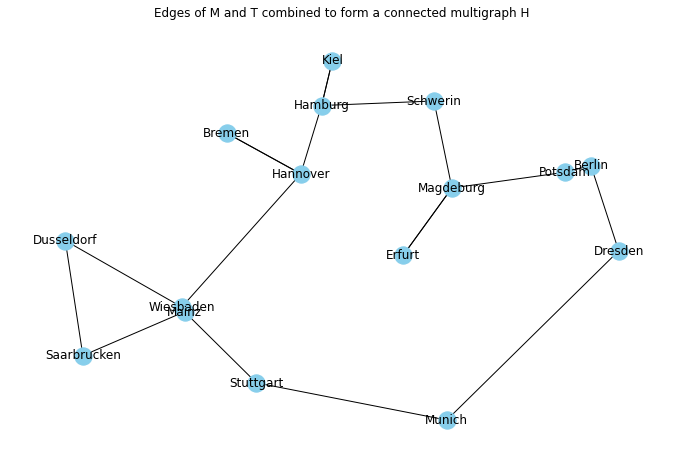

In [27]:
MG = multigraph(G)

plt.figure(figsize = (12, 8))

nx.draw_networkx(MG, pos = positions, labels = labels, node_color = "skyblue")

plt.title("Edges of M and T combined to form a connected multigraph H")

plt.axis("off")

plt.savefig("../output/Edges of M and T combined to form a connected multigraph H.jpeg",
           dpi = 300)

plt.show()

### 4. Build an Eulerian circuit using the edges of M and T

In [28]:
#@not_implemented_for("directed")
def christofides(G, weight="weight", tree=None):
    """Approximate a solution of the traveling salesman problem

    Compute a 3/2-approximation of the traveling salesman problem
    in a complete undirected graph using Christofides [1]_ algorithm.

    Parameters
    ----------
    G : Graph
        `G` should be a complete weighted undirected graph.
        The distance between all pairs of nodes should be included.

    weight : string, optional (default="weight")
        Edge data key corresponding to the edge weight.
        If any edge does not have this attribute the weight is set to 1.

    tree : NetworkX graph or None (default: None)
        A minimum spanning tree of G. Or, if None, the minimum spanning
        tree is computed using :func:`networkx.minimum_spanning_tree`

    Returns
    -------
    list
        List of nodes in `G` along a cycle with a 3/2-approximation of
        the minimal Hamiltonian cycle.

    References
    ----------
    .. [1] Christofides, Nicos. "Worst-case analysis of a new heuristic for
       the travelling salesman problem." No. RR-388. Carnegie-Mellon Univ
       Pittsburgh Pa Management Sciences Research Group, 1976.
    """
    # Remove selfloops if necessary
    loop_nodes = nx.nodes_with_selfloops(G)
    try:
        node = next(loop_nodes)
    except StopIteration:
        pass
    else:
        G = G.copy()
        G.remove_edge(node, node)
        G.remove_edges_from((n, n) for n in loop_nodes)
    # Check that G is a complete graph
    N = len(G) - 1
    # This check ignores selfloops which is what we want here.
    if any(len(nbrdict) != N for n, nbrdict in G.adj.items()):
        raise nx.NetworkXError("G must be a complete graph.")

    if tree is None:
        tree = nx.minimum_spanning_tree(G, weight=weight)
    L = G.copy()
    L.remove_nodes_from([v for v, degree in tree.degree if not (degree % 2)])
    MG = nx.MultiGraph()
    MG.add_edges_from(tree.edges)
    edges = nx.min_weight_matching(L, maxcardinality=True, weight=weight)
    MG.add_edges_from(edges)
    return _shortcutting(nx.eulerian_circuit(MG))


def _shortcutting(circuit):
    """Remove duplicate nodes in the path"""
    nodes = []
    for u, v in circuit:
        if v in nodes:
            continue
        if not nodes:
            nodes.append(u)
        nodes.append(v)
    nodes.append(nodes[0])
    return nodes

In [29]:
eulerian_cycle = christofides(G)
eulerian_cycle

[0, 2, 10, 14, 9, 15, 12, 3, 6, 1, 5, 7, 13, 8, 4, 11, 0]

In [30]:
eulerian_edge_list = list(nx.utils.pairwise(eulerian_cycle))

eulerian_edge_list

[(0, 2),
 (2, 10),
 (10, 14),
 (14, 9),
 (9, 15),
 (15, 12),
 (12, 3),
 (3, 6),
 (6, 1),
 (1, 5),
 (5, 7),
 (7, 13),
 (13, 8),
 (8, 4),
 (4, 11),
 (11, 0)]

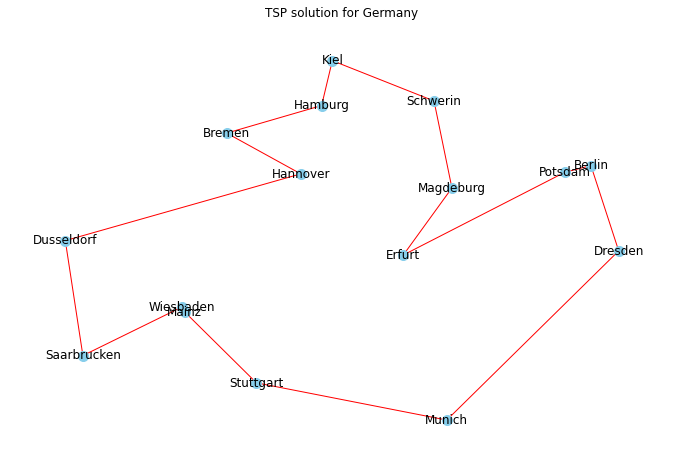

In [31]:
plt.figure(figsize = (12, 8))

#TSP solution route
nx.draw_networkx(G, pos = positions, labels = labels, node_size=100, node_color = "skyblue",
                 edgelist=eulerian_edge_list, edge_color="red", width = 1
                )

plt.axis("off")

plt.title("TSP solution for Germany")
plt.savefig("../output/tsp solution 1.jpeg",
           dpi = 300)

plt.show()

H = G.copy()

# Calculating the distances between the nodes as edge's weight.
for i in range(len(pos)):
    for j in range(i + 1, len(pos)):
        
        #Multidimensional Euclidean distance from the origin to a point.
        #euclidean distance between (x1, y1) and (x2, y2) is ((x2-x1)**2 + (y2-y1)**2)**0.5
        dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
        dist = dist
        G.add_edge(i, j, weight=dist)
        
        

cycle = nx_app.christofides(G, weight="weight")

edge_list = list(nx.utils.pairwise(cycle))

In [32]:
#Create a dictionary of node and capital for labels
labels = {node:capital for node, capital in zip(nodes, capitals)}
tsp_cycle = [labels[value] for value in cycle]
print (tsp_cycle)

['Berlin', 'Dresden', 'Munich', 'Stuttgart', 'Mainz', 'Wiesbaden', 'Saarbrucken', 'Dusseldorf', 'Hannover', 'Bremen', 'Hamburg', 'Kiel', 'Schwerin', 'Magdeburg', 'Erfurt', 'Potsdam', 'Berlin']


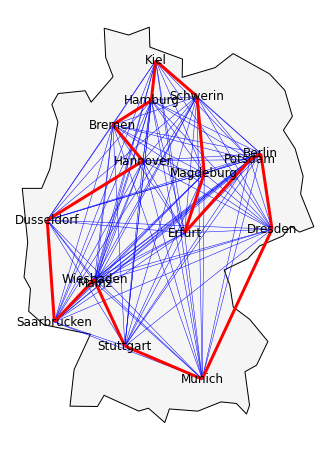

In [33]:
fig, ax = plt.subplots(figsize = (12, 8))
germany.plot(color = "whitesmoke", edgecolor = "black", ax = ax)

#All possible routes
nx.draw_networkx_edges(H, pos = positions, edge_color="blue", width=0.5, ax = ax)

#TSP solution route
nx.draw_networkx(G, pos = positions, labels = labels, node_size=0,
                 edgelist=edge_list, edge_color="red", width = 3, ax = ax)

plt.axis("off")
plt.show()

In [34]:
H.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))

In [35]:
H.edges

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (11, 12), (11, 13), (11, 14), (11, 15), 

In [36]:
len(H.edges)

120

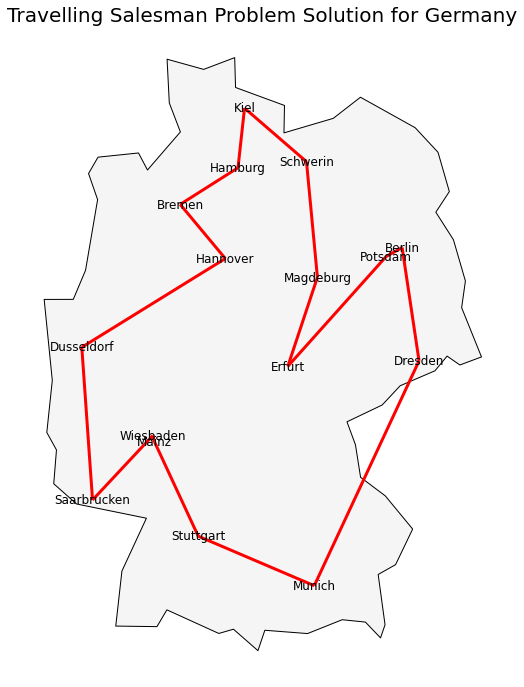

In [37]:
fig, ax = plt.subplots(figsize = (20, 12))
germany.plot(ax = ax, 
          color = "whitesmoke",
          edgecolor = "black")

# Draw the route
nx.draw_networkx(
    G,
    pos = positions,
    labels = labels,
    edgelist=edge_list,
    edge_color="red",
    #node_color = "#ffffff", #transparent
    node_size=0,
    width=3,
    ax = ax,
    #bbox = dict(facecolor = "white", boxstyle = "round",ec = "silver")
)

plt.title("Travelling Salesman Problem Solution for Germany",
         fontsize = 20)

plt.axis("off")
plt.savefig("../output/tsp solution with red route.jpeg",
           dpi = 300)


plt.show()

# Plotting the solution with unique color for each edge

https://www.mathsisfun.com/hexadecimal-decimal-colors.html#:~:text=Hexadecimals&text=So%20one%20hexadecimal%20digit%20can,256%20different%20levels%20of%20color.

#RRGGBB 

Six hexadecimal digits starting with a # represent a color.

- First two hexadecimal digits represent proportion of red.

- Third and fourth hexadecimal digits represent proportion of green.

- Fifth and sixth hexadecimal digits represent proportion of blue.



- f is the highest hexadecimal number that corresponds to 15 in decimal system.

- #000000 is black. And #ffffff is white.

- get random hexadecimal number having  six hexadecimal digits from 0 to ffffff in hexadecimal system


In [38]:
import random
get_colors = lambda n: list(map(lambda i: "#" +"%06x" % random.randint(0, 0xffffff),range(n)))
get_colors(5)

['#e87343', '#ee2904', '#cca0c8', '#301f67', '#1b0c04']

In [39]:
type(get_colors)

function

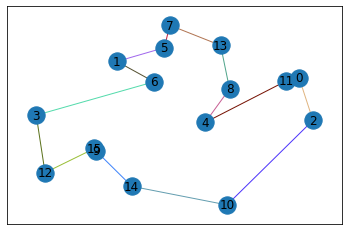

In [40]:
nx.draw_networkx(G,
                pos = positions,
                edgelist = edge_list,
                edge_color = get_colors(16))

In [41]:
get_colors(16)

['#59d5cd',
 '#9d1a31',
 '#9e4eed',
 '#b75ef2',
 '#242cc0',
 '#26b7c7',
 '#177a7b',
 '#591859',
 '#adea1f',
 '#f8a550',
 '#759ce9',
 '#ef7d8d',
 '#892659',
 '#d84412',
 '#016bc8',
 '#579665']

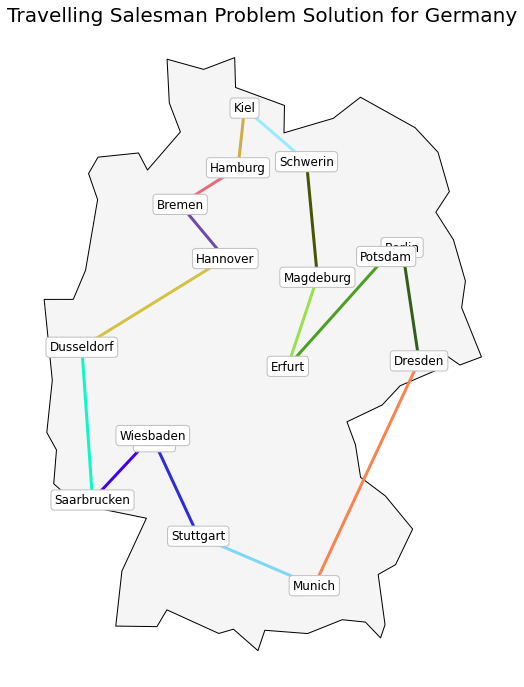

In [42]:
fig, ax = plt.subplots(figsize = (20, 12))

germany.plot(ax = ax, color = "whitesmoke", edgecolor = "black")

# Draw the route
nx.draw_networkx(G, pos = positions, labels = labels, 
                 edgelist=edge_list, edge_color=get_colors(16), width=3,
                 node_color = "snow", node_shape = "s", node_size = 300,
                 
                 bbox = dict(facecolor = "#ffffff", boxstyle = "round", ec = "silver"),
                 ax = ax
                 )

plt.title("Travelling Salesman Problem Solution for Germany", fontsize = 20)
plt.axis("off")
plt.savefig("../output/tsp solution for germany.jpeg",
           dpi = 300)
plt.show()

# Plot the solution using Folium Map

In [43]:
coordinates

[(13.3888599, 52.5170365),
 (8.8071646, 53.0758196),
 (13.7381437, 51.0493286),
 (6.7763137, 51.2254018),
 (11.0287364, 50.9777974),
 (10.000654, 53.550341),
 (9.7385532, 52.3744779),
 (10.135555, 54.3227085),
 (11.6399609, 52.1315889),
 (8.2762513, 50.0012314),
 (11.5753822, 48.1371079),
 (13.0591397, 52.4009309),
 (6.997495426501035, 49.247108100000005),
 (11.4148038, 53.6288297),
 (9.1800132, 48.7784485),
 (8.2416556, 50.0820384)]

In [44]:
folium_coordinates = []
for x,y in coordinates:
    folium_coordinates.append([y,x])
    
folium_coordinates

[[52.5170365, 13.3888599],
 [53.0758196, 8.8071646],
 [51.0493286, 13.7381437],
 [51.2254018, 6.7763137],
 [50.9777974, 11.0287364],
 [53.550341, 10.000654],
 [52.3744779, 9.7385532],
 [54.3227085, 10.135555],
 [52.1315889, 11.6399609],
 [50.0012314, 8.2762513],
 [48.1371079, 11.5753822],
 [52.4009309, 13.0591397],
 [49.247108100000005, 6.997495426501035],
 [53.6288297, 11.4148038],
 [48.7784485, 9.1800132],
 [50.0820384, 8.2416556]]

In [45]:
edge_list

[(0, 2),
 (2, 10),
 (10, 14),
 (14, 9),
 (9, 15),
 (15, 12),
 (12, 3),
 (3, 6),
 (6, 1),
 (1, 5),
 (5, 7),
 (7, 13),
 (13, 8),
 (8, 4),
 (4, 11),
 (11, 0)]

https://stackoverflow.com/questions/60578408/is-it-possible-to-draw-paths-in-folium

In [46]:
print("The route of the traveller is:", cycle)

The route of the traveller is: [0, 2, 10, 14, 9, 15, 12, 3, 6, 1, 5, 7, 13, 8, 4, 11, 0]


In [47]:
route = []
for stop in cycle:
    route.append(folium_coordinates[stop])
route


[[52.5170365, 13.3888599],
 [51.0493286, 13.7381437],
 [48.1371079, 11.5753822],
 [48.7784485, 9.1800132],
 [50.0012314, 8.2762513],
 [50.0820384, 8.2416556],
 [49.247108100000005, 6.997495426501035],
 [51.2254018, 6.7763137],
 [52.3744779, 9.7385532],
 [53.0758196, 8.8071646],
 [53.550341, 10.000654],
 [54.3227085, 10.135555],
 [53.6288297, 11.4148038],
 [52.1315889, 11.6399609],
 [50.9777974, 11.0287364],
 [52.4009309, 13.0591397],
 [52.5170365, 13.3888599]]

In [48]:
import folium

folium_coordinates = []
for x,y in coordinates:
    folium_coordinates.append([y,x])
    
route = []
for stop in cycle:
    route.append(folium_coordinates[stop])
    
m1 = folium.Map(location = [51, 10],   #latitude (N), longitude (E)
                tiles = "OpenStreetMap", 
                zoom_start= 6
                )

for coordinate, capital in zip(folium_coordinates, capitals):
    folium.Marker(location = coordinate,
                 popup = capital).add_to(m1)
    
folium.PolyLine(route).add_to(m1)
    
m1.save("germany tsp.html")

m1

In [49]:
import pandas as pd
df = pd.DataFrame()
gpd 
for source, target, weight in G.edges(data = True):
    df.loc[source, target] = weight["weight"]
    df.loc[target, source] = weight["weight"]

Sort column based on names in pandas dataframe:

https://stackoverflow.com/questions/11067027/sorting-columns-in-pandas-dataframe-based-on-column-name

In [50]:
df = df.reindex(sorted(df.columns), axis=1)
df.fillna(0, inplace = True)

df.columns = capitals
df.index = capitals
df


,Berlin,Bremen,Dresden,Dusseldorf,Erfurt,Hamburg,Hannover,Kiel,Magdeburg,Mainz,Munich,Potsdam,Saarbrucken,Schwerin,Stuttgart,Wiesbaden
Berlin,0.000000,4.615644,1.508697,6.737513,2.817701,3.542267,3.653089,3.720812,1.790871,5.698074,4.740514,0.349565,7.179274,2.265608,5.629514,5.694113
Bremen,4.615644,0.000000,5.331156,2.747435,3.055663,1.284363,1.165918,1.821909,2.986019,3.120090,5.661617,4.305202,4.234848,2.665634,4.313515,3.046724
Dresden,1.508697,5.331156,0.000000,6.964056,2.710351,4.497098,4.213401,4.867614,2.360860,5.561544,3.627474,1.512572,6.977416,3.471561,5.092490,5.580953
Dusseldorf,6.737513,2.747435,6.964056,0.000000,4.259625,3.975137,3.177301,4.569224,4.947347,1.936080,5.706892,6.391852,1.990620,5.224180,3.430066,1.858630
Erfurt,2.817701,3.055663,2.710351,4.259625,0.000000,2.770367,1.901391,3.462110,1.305691,2.920592,2.892808,2.479485,4.387048,2.678996,2.873136,2.927491
Hamburg,3.542267,1.284363,4.497098,3.975137,2.770367,0.000000,1.204720,0.784060,2.167991,3.945851,5.637629,3.267335,5.247549,1.416326,4.841943,3.888856
Hannover,3.653089,1.165918,4.213401,3.177301,1.901391,1.204720,0.000000,1.988269,1.916858,2.787584,4.618360,3.320692,4.158586,2.093613,3.639147,2.737879
Kiel,3.720812,1.821909,4.867614,4.569224,3.462110,0.784060,1.988269,0.000000,2.657864,4.704485,6.350965,3.498654,5.967339,1.455316,5.626000,4.644366
Magdeburg,1.790871,2.986019,2.360860,4.947347,1.305691,2.167991,1.916858,2.657864,0.000000,3.981578,3.995003,1.444512,5.465594,1.514076,4.158713,3.968518
Mainz,5.698074,3.120090,5.561544,1.936080,2.920592,3.945851,2.787584,4.704485,3.981578,0.000000,3.789356,5.351129,1.484560,4.796872,1.520521,0.087901


In [51]:
df = df.round(2)

df

,Berlin,Bremen,Dresden,Dusseldorf,Erfurt,Hamburg,Hannover,Kiel,Magdeburg,Mainz,Munich,Potsdam,Saarbrucken,Schwerin,Stuttgart,Wiesbaden
Berlin,0.00,4.62,1.51,6.74,2.82,3.54,3.65,3.72,1.79,5.70,4.74,0.35,7.18,2.27,5.63,5.69
Bremen,4.62,0.00,5.33,2.75,3.06,1.28,1.17,1.82,2.99,3.12,5.66,4.31,4.23,2.67,4.31,3.05
Dresden,1.51,5.33,0.00,6.96,2.71,4.50,4.21,4.87,2.36,5.56,3.63,1.51,6.98,3.47,5.09,5.58
Dusseldorf,6.74,2.75,6.96,0.00,4.26,3.98,3.18,4.57,4.95,1.94,5.71,6.39,1.99,5.22,3.43,1.86
Erfurt,2.82,3.06,2.71,4.26,0.00,2.77,1.90,3.46,1.31,2.92,2.89,2.48,4.39,2.68,2.87,2.93
Hamburg,3.54,1.28,4.50,3.98,2.77,0.00,1.20,0.78,2.17,3.95,5.64,3.27,5.25,1.42,4.84,3.89
Hannover,3.65,1.17,4.21,3.18,1.90,1.20,0.00,1.99,1.92,2.79,4.62,3.32,4.16,2.09,3.64,2.74
Kiel,3.72,1.82,4.87,4.57,3.46,0.78,1.99,0.00,2.66,4.70,6.35,3.50,5.97,1.46,5.63,4.64
Magdeburg,1.79,2.99,2.36,4.95,1.31,2.17,1.92,2.66,0.00,3.98,4.00,1.44,5.47,1.51,4.16,3.97
Mainz,5.70,3.12,5.56,1.94,2.92,3.95,2.79,4.70,3.98,0.00,3.79,5.35,1.48,4.80,1.52,0.09


In [52]:
df.to_excel("../output/tsp_distance_matrix.xlsx")

In [53]:
labels

{0: 'Berlin',
 1: 'Bremen',
 2: 'Dresden',
 3: 'Dusseldorf',
 4: 'Erfurt',
 5: 'Hamburg',
 6: 'Hannover',
 7: 'Kiel',
 8: 'Magdeburg',
 9: 'Mainz',
 10: 'Munich',
 11: 'Potsdam',
 12: 'Saarbrucken',
 13: 'Schwerin',
 14: 'Stuttgart',
 15: 'Wiesbaden'}

In [54]:
edge_list_cities = []

for x,y in edge_list:
    edge_list_cities.append((labels[x], labels[y]))
    
edge_list_cities

[('Berlin', 'Dresden'),
 ('Dresden', 'Munich'),
 ('Munich', 'Stuttgart'),
 ('Stuttgart', 'Mainz'),
 ('Mainz', 'Wiesbaden'),
 ('Wiesbaden', 'Saarbrucken'),
 ('Saarbrucken', 'Dusseldorf'),
 ('Dusseldorf', 'Hannover'),
 ('Hannover', 'Bremen'),
 ('Bremen', 'Hamburg'),
 ('Hamburg', 'Kiel'),
 ('Kiel', 'Schwerin'),
 ('Schwerin', 'Magdeburg'),
 ('Magdeburg', 'Erfurt'),
 ('Erfurt', 'Potsdam'),
 ('Potsdam', 'Berlin')]

In [55]:
("Stuttgart","Munich") in edge_list_cities

False